In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<function matplotlib.pyplot.show(*args, **kw)>

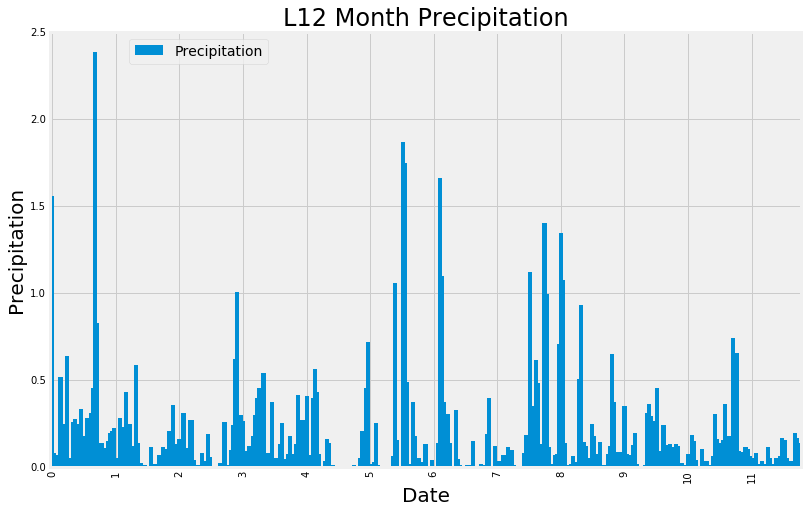

In [54]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
newest = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
# Calculate the date 1 year ago from the last data point in the database
L12 = dt.datetime.strptime(newest, '%Y-%m-%d') - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= L12).\
                    group_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
# Sort the dataframe by date
#already sorted
# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(kind='bar', width=2, figsize=(12,8))
plt.locator_params(axis='x', nbins=12)
ax.tick_params(axis='y', labelsize=10)
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="14")
plt.title("L12 Month Precipitation", size=24)
plt.ylabel("Precipitation", size=20)
plt.xlabel("Date", size=20)
plt.savefig("../Instructions/Precipitation.png")
plt.show

![precipitation](Images/precipitation.png)

In [35]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [36]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [42]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
bestres = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
bestres

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [44]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
best = bestres[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best).all()

[(54.0, 71.66378066378067, 85.0)]

<function matplotlib.pyplot.show(*args, **kw)>

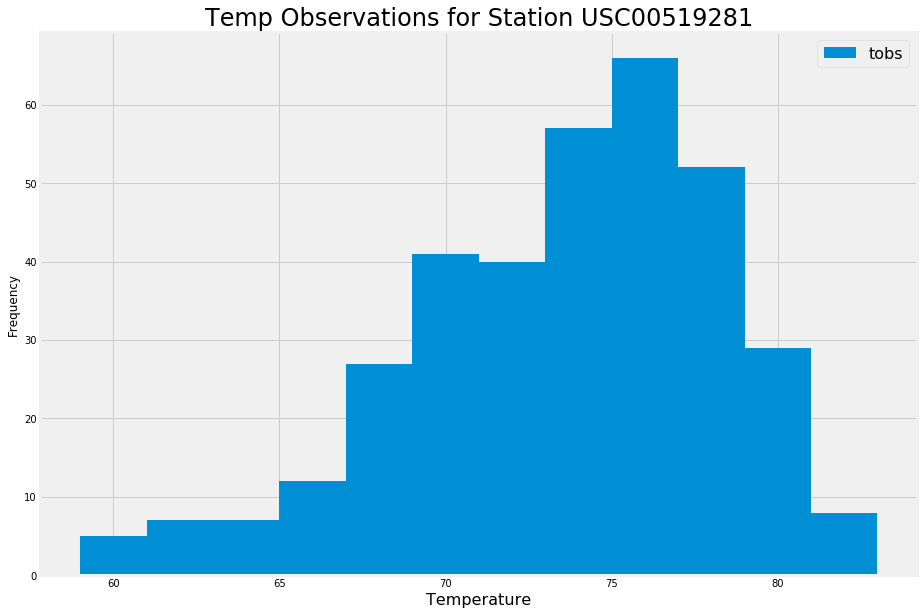

In [53]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temres = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == best).\
                filter(Measurement.date >= L12).all()
temp = pd.DataFrame(temres)
temp.set_index('station', inplace=True)
temp.plot.hist(by='station', bins=12, figsize=(14,10))
plt.title("Temp Observations for Station " + best, fontsize=24)
plt.xlabel("Temperature", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("../Instructions/StationTemp.png")
plt.show

In [55]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    #TMIN, TAVG, and TMAX for a list of dates.
    calctemps = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
    #Args:
        #start_date (string): A date string in the format %Y-%m-%d
        #end_date (string): A date string in the format %Y-%m-%d
        
   # Returns:
   #     TMIN, TAVE, and TMAX
    #"""
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [61]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps(L12,newest)
trip

[(58.0, 74.57894736842105, 87.0)]

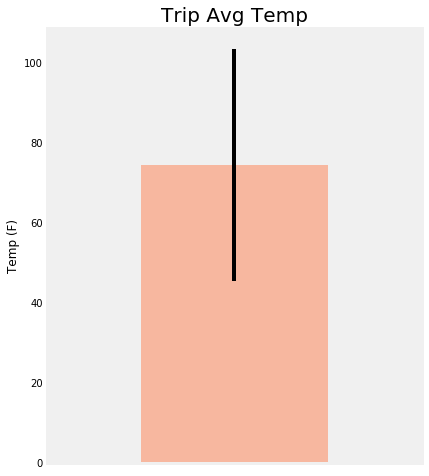

In [65]:
# Plot the results from your previous query as a bar chart. 
tdf = pd.DataFrame(trip, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
# Use "Trip Avg Temp" as your Title
avgt = tdf['Avg Temp']
# Use the average temperature for the y value
min_max_temp = tdf.iloc[0]['Max Temp'] - tdf.iloc[0]['Min Temp']
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avgt.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("../Instructions/TripTempSummary.png")
plt.show()